## Football Multimodal Summarization of Highlights

In [2]:
import os
import json
import subprocess
from math import ceil
from pathlib import Path
from pydub import AudioSegment
from moviepy import VideoFileClip
from datetime import timedelta
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

/home/droidis/PycharmProjects/Multimodal/.venv/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.1)
  from scipy.sparse import csr_matrix, issparse


Fire API extract metrics

In [3]:

# CONFIG
video_path = "FULL MATCH _ Liverpool 3-1 Manchester City _ FA Community Shield 2022-23.mp4"
output_wav = "LIV-MAC.wav"
segment_duration_ms = 5 * 60 * 1000  # 30 minutes in milliseconds
segments_dir = "segments-LIV-MAC"
final_output_json = "final_features-LIV-MAC.json"
api_script = "send_data_to_api.py"  # from the Behavioral Signals repo

# Extract audio from MP4
def extract_audio(video_path, wav_path):
    print("🎵 Extracting audio from MP4...")
    video = VideoFileClip(video_path)
    audio = video.audio
    audio.write_audiofile(wav_path, codec="pcm_s16le")
    print(f"✅ Audio saved to {wav_path}")

#  Split audio into segments
def split_audio(wav_path, output_dir):
    print("✂️ Splitting audio...")
    audio = AudioSegment.from_wav(wav_path)
    total_length = len(audio)
    os.makedirs(output_dir, exist_ok=True)

    num_parts = ceil(total_length / segment_duration_ms)
    for i in range(num_parts):
        start = i * segment_duration_ms
        end = min(start + segment_duration_ms, total_length)
        segment = audio[start:end]
        segment_path = os.path.join(output_dir, f"part_{i}.wav")
        segment.export(segment_path, format="wav")
        print(f"  → Saved: {segment_path}")
    return num_parts

# Send to API & collect responses
def process_segments_with_api(num_parts):
    print("📡 Sending segments to API...")
    for i in range(num_parts):
        segment_path = os.path.join(segments_dir, f"part_{i}.wav")
        subprocess.run(["python3", api_script, "-i", segment_path], check=True)


global_id = 0  # unique ID counter

def merge_jsons(num_parts):
    print("🧩 Merging responses...")
    merged = []
    offset_seconds = 0.0
    global_id = 0

    for i in range(num_parts):
        segment_file = os.path.join(segments_dir, f"part_{i}.wav")
        json_file = f"{segment_file[:-4]}_features.json"

        if not os.path.exists(json_file):
            print(f"⚠️ Warning: Missing {json_file}, skipping.")
            continue

        with open(json_file) as f:
            data = json.load(f)

        for entry in data:
            try:
                entry["startTime"] = str(float(entry["startTime"]) + offset_seconds)
                entry["endTime"] = str(float(entry["endTime"]) + offset_seconds)
                entry["id"] = str(global_id)
                merged.append(entry)
                global_id += 1
            except (KeyError, ValueError, TypeError) as e:
                print(f"⚠️ Skipping malformed entry: {entry} — Error: {e}")

        audio = AudioSegment.from_wav(segment_file)
        offset_seconds += len(audio) / 1000.0

    with open(final_output_json, "w") as f:
        json.dump(merged, f, indent=2)
    print(f"✅ Final merged JSON saved to {final_output_json}")


extract_audio(video_path, output_wav)

# Split extracted audio into segments
num_parts = split_audio(output_wav, segments_dir)

# Send each segment to the API and save results
process_segments_with_api(num_parts)

from pathlib import Path

segments_dir = Path(segments_dir)
valid_indices = [
    int(f.stem.split("_")[1])
    for f in segments_dir.glob("part_*_features.json")
    if (segments_dir / f"part_{f.stem.split('_')[1]}.wav").exists()
]

num_parts = max(valid_indices) + 1  # assuming files are sequential
merge_jsons(num_parts)



🎵 Extracting audio from MP4...
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'mp42', 'minor_version': '0', 'compatible_brands': 'isommp42', 'creation_time': '2025-03-19T02:13:34.000000Z', 'encoder': 'Google'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [640, 360], 'bitrate': 251, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(Main)', 'metadata': {'Metadata': '', 'creation_time': '2025-03-19T02:13:34.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/18/2025.', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': 'eng', 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'creation_time': '2025-03-19T02:13:34.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/18/2025.', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 7118.1

chunk:   4%|▍         | 6436/156955 [00:03<02:10, 1152.74it/s, now=None]

KeyboardInterrupt: 

Add Saliency Metrics - Time format

In [ ]:
INPUT_JSON = "final_features-CRY-MAC.json"
OUTPUT_JSON = "output_segments_with_hhmmss-CRY-MAC.json"

# === Utility: Convert seconds to hh:mm:ss ===
def seconds_to_hhmmss(seconds):
    return str(timedelta(seconds=float(seconds))).split(".")[0]


with open(INPUT_JSON, "r") as f:
    data = json.load(f)

sum_all_list = []
strong_list = []

# Process each segment
for segment in data:
    # Convert time
    segment["startTime_hhmmss"] = seconds_to_hhmmss(segment["startTime"])
    segment["endTime_hhmmss"] = seconds_to_hhmmss(segment["endTime"])

    # Extract posteriors
    emotions = segment.get("emotion_posteriors", {})
    positivity = segment.get("positivity_posteriors", {})
    strength = segment.get("strength_posteriors", {})

    happy = float(emotions.get("happy", 0))
    positive = float(positivity.get("positive", 0))
    angry = float(emotions.get("angry", 0))
    negative = float(positivity.get("negative", 0))
    strong = float(strength.get("strong", 0))

    happy_sum = (happy + positive) * strong
    angry_sum = (angry + negative) * strong
    sum_all = happy_sum + angry_sum

    if strong >= 0.7:
        sum_all *= 1.5

    segment["happy_sum"] = happy_sum
    segment["angry_sum"] = angry_sum
    segment["sum_all"] = sum_all

    # Accumulate for stats
    sum_all_list.append(sum_all)
    strong_list.append(strong)

# Compute summary statistics
def compute_stats(values):
    return {
        "mean": float(np.mean(values)),
        "std": float(np.std(values)),
        "min": float(np.min(values)),
        "max": float(np.max(values)),
        "median": float(np.median(values)),
    }

summary_stats = {
    "summary_statistics": {
        "sum_all": compute_stats(sum_all_list),
        "strong": compute_stats(strong_list)
    }
}

# Save full output with stats at the end
output_data = data + [summary_stats]

with open(OUTPUT_JSON, "w") as f:
    json.dump(output_data, f, indent=2)

print("✅ Processed segments saved with summary statistics.")


Summarize Highlights


🔍 Summary of raw sum_saliencies:
  Count: 188
  Min  : 0.000064
  Max  : 2.477947
  Mean : 0.272586
  Std  : 0.500512
📊 Saliency scatter plot saved to 'saliency_scatter_plot.png'
✅ Extracted top 6% (11 segments) to: highlights-PORT-SPAIN.json


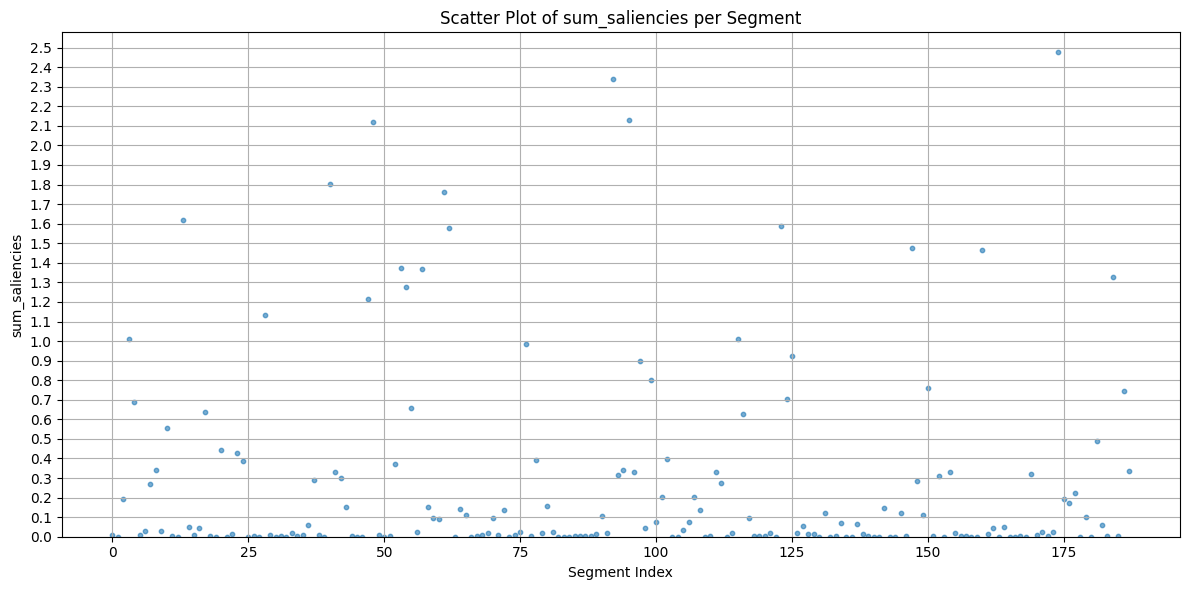

In [4]:

INPUT_JSON = "output_segments_with_hhmmss-PORT-SPAIN.json"
OUTPUT_JSON = "highlights-PORT-SPAIN.json"
MIN_DURATION = 4.0  # seconds
TOP_PERCENT = 6  # percentage of top saliency segments to keep

# Load data
with open(INPUT_JSON, "r") as f:
    data = json.load(f)

# Filter valid segments and extract saliencies
valid_segments = [
    seg for seg in data
    if float(seg.get("endTime", 0)) - float(seg.get("startTime", 0)) > MIN_DURATION
]
sum_saliencies = [float(seg.get("sum_all", 0)) for seg in valid_segments]

#  Stats
print("🔍 Summary of raw sum_saliencies:")
print(f"  Count: {len(sum_saliencies)}")
print(f"  Min  : {min(sum_saliencies):.6f}")
print(f"  Max  : {max(sum_saliencies):.6f}")
print(f"  Mean : {np.mean(sum_saliencies):.6f}")
print(f"  Std  : {np.std(sum_saliencies):.6f}")

#Plot and save
plt.figure(figsize=(12, 6))
plt.scatter(range(len(sum_saliencies)), sum_saliencies, alpha=0.6, s=10)
plt.title("Scatter Plot of sum_saliencies per Segment")
plt.xlabel("Segment Index")
plt.ylabel("sum_saliencies")
plt.grid(True)

y_max = max(sum_saliencies)
plt.yticks(np.arange(0, y_max + 0.1, 0.1))
plt.ylim(0, y_max + 0.1)

plt.tight_layout()
plot_path = "saliency_scatter_plot.png"
plt.savefig(plot_path, dpi=300)
print(f"📊 Saliency scatter plot saved to '{plot_path}'")

# Keep top X%
num_top = max(1, int(len(valid_segments) * TOP_PERCENT / 100))
top_segments = sorted(valid_segments, key=lambda x: float(x.get("sum_all", 0)), reverse=True)[:num_top]


with open(OUTPUT_JSON, "w") as f:
    json.dump(top_segments, f, indent=2)

print(f"✅ Extracted top {TOP_PERCENT}% ({len(top_segments)} segments) to: {OUTPUT_JSON}")

Evaluation

In [6]:
def hhmmss_to_seconds(hhmmss: str) -> int:
    """Convert 'hh:mm:ss' string to total seconds."""
    t = datetime.strptime(hhmmss, "%H:%M:%S")
    return t.hour * 3600 + t.minute * 60 + t.second


def load_segments(path):
    with open(path) as f:
        return [
            (hhmmss_to_seconds(d["startTime_hhmmss"]), hhmmss_to_seconds(d["endTime_hhmmss"]))
            for d in json.load(f)
        ]


def compute_global_iou(preds, gts):
    """Calculate IoU based on total overlapping time vs total union time."""
    pred_mask = np.zeros(max(e for _, e in preds + gts) + 1, dtype=bool)
    gt_mask = np.zeros_like(pred_mask)

    for s, e in preds:
        pred_mask[s:e + 1] = True
    for s, e in gts:
        gt_mask[s:e + 1] = True

    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union > 0 else 0.0


def relaxed_match(pred, gt, threshold=0.9):
    """Return True if prediction covers at least threshold proportion of GT."""
    overlap = max(0, min(pred[1], gt[1]) - max(pred[0], gt[0]))
    gt_length = gt[1] - gt[0]
    return overlap / gt_length >= threshold


def evaluate(preds, gts, mode="strict"):
    pred_mask = np.zeros(max(e for _, e in preds + gts) + 1, dtype=bool)
    gt_mask = np.zeros_like(pred_mask)

    if mode == "flexible":
        matched_gts = set()
        for ps, pe in preds:
            for idx, (gs, ge) in enumerate(gts):
                if idx not in matched_gts and relaxed_match((ps, pe), (gs, ge)):
                    pred_mask[gs:ge + 1] = True
                    gt_mask[gs:ge + 1] = True
                    matched_gts.add(idx)
                    break
            else:
                pred_mask[ps:pe + 1] = True
    else:
        for s, e in preds:
            pred_mask[s:e + 1] = True
        for s, e in gts:
            gt_mask[s:e + 1] = True

    for s, e in gts:
        gt_mask[s:e + 1] = True

    tp = np.logical_and(pred_mask, gt_mask).sum()
    fp = np.logical_and(pred_mask, ~gt_mask).sum()
    fn = np.logical_and(~pred_mask, gt_mask).sum()

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    auc = roc_auc_score(gt_mask, pred_mask) if len(set(gt_mask)) > 1 else None

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "global_iou": compute_global_iou(preds, gts),
        "auc": auc,
        "tp": tp,
        "fp": fp,
        "fn": fn,
    }


# Run evaluation
print("Choose Evaluation Mode:\n 1. Strict (exact second-based overlap)\n 2. Flexible (≥90% coverage equals full match)")
mode_input = input("Enter 1 or 2: ").strip()
mode = "flexible" if mode_input == "2" else "strict"

ground_truth = load_segments("highlights-GROUNDTRUTH.json")
predictions = load_segments("highlights-PORT-SPAIN.json")

metrics = evaluate(predictions, ground_truth, mode=mode)

print(f"\n📊 Evaluation Summary ({mode.capitalize()} Mode)")
for k, v in metrics.items():
    if isinstance(v, float):
        print(f"{k:>12}: {v:.4f}")
    else:
        print(f"{k:>12}: {v}")


Choose Evaluation Mode:
 1. Strict (exact second-based overlap)
 2. Flexible (≥90% coverage equals full match)

📊 Evaluation Summary (Strict Mode)
   precision: 0.5870
      recall: 0.9153
          f1: 0.7152
  global_iou: 0.5567
         auc: 0.9542
          tp: 54
          fp: 38
          fn: 5


Montage

In [8]:

VIDEO_PATH = "FULL MATCH_ Portugal v Spain _ 2018 FIFA World Cup.mp4"
HIGHLIGHTS_JSON = "highlights-PORT-SPAIN.json"
CLIPS_DIR = Path("highlight_clips")
FINAL_OUTPUT = "montage_final.mp4"
CLIP_LIST_FILE = CLIPS_DIR / "clip_list.txt"
PADDING = 10  # seconds to add before and after each segment

# Load and pad segments
with open(HIGHLIGHTS_JSON, "r") as f:
    highlights = json.load(f)

# Apply padding
padded_segments = []
for seg in highlights:
    start = max(0, float(seg["startTime"]) - PADDING)
    end = float(seg["endTime"]) + PADDING
    padded_segments.append((start, end))

# Sort and merge overlapping
padded_segments.sort()
merged_segments = []

for start, end in padded_segments:
    if not merged_segments:
        merged_segments.append([start, end])
    else:
        prev_start, prev_end = merged_segments[-1]
        if start <= prev_end:  # Overlap
            merged_segments[-1][1] = max(prev_end, end)
        else:
            merged_segments.append([start, end])

# Create clips directory
CLIPS_DIR.mkdir(parents=True, exist_ok=True)

#  Extract merged segments
clip_paths = []

for idx, (start, end) in enumerate(merged_segments):
    duration = end - start
    clip_filename = f"clip_{idx:03d}.mp4"
    clip_output = CLIPS_DIR / clip_filename
    clip_paths.append(clip_filename)

    cmd = [
        "ffmpeg",
        "-ss", str(start),
        "-i", VIDEO_PATH,
        "-t", str(duration),
        "-c", "copy",
        "-avoid_negative_ts", "1",
        str(clip_output)
    ]
    subprocess.run(cmd, check=True)
    print(f"🎞️  Saved: {clip_output}")

#  Write list file for FFmpeg concat
with open(CLIP_LIST_FILE, "w") as f:
    for filename in clip_paths:
        f.write(f"file '{filename}'\n")

# Concatenate all clips
concat_cmd = [
    "ffmpeg",
    "-f", "concat",
    "-safe", "0",
    "-i", CLIP_LIST_FILE.name,
    "-c", "copy",
    f"../{FINAL_OUTPUT}"
]

subprocess.run(concat_cmd, check=True, cwd=CLIPS_DIR)
print(f"✅ Final highlight montage saved to: {FINAL_OUTPUT}")

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

🎞️  Saved: highlight_clips/clip_000.mp4
🎞️  Saved: highlight_clips/clip_001.mp4
🎞️  Saved: highlight_clips/clip_002.mp4
🎞️  Saved: highlight_clips/clip_003.mp4


Output #0, mp4, to 'highlight_clips/clip_002.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: isommp42
    encoder         : Lavf58.76.100
  Stream #0:0(und): Video: h264 (Main) (avc1 / 0x31637661), yuv420p(tv, bt709), 640x360 [SAR 1:1 DAR 16:9], q=2-31, 561 kb/s, 30 fps, 30 tbr, 15360 tbn, 15360 tbc (default)
    Metadata:
      creation_time   : 2024-09-14T10:00:20.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 09/14/2024.
      vendor_id       : [0][0][0][0]
  Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 128 kb/s (default)
    Metadata:
      creation_time   : 2024-09-14T10:00:20.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 09/14/2024.
      vendor_id       : [0][0][0][0]
Stream mapping:
  Stream #0:0 -> #0:0 (copy)
  Stream #0:1 -> #0:1 (copy)
Press [q] to stop, [?] for help
frame=  868 fps=0.0 q=-1.0 Lsize=    2632kB time=00:00:27.3

🎞️  Saved: highlight_clips/clip_004.mp4
🎞️  Saved: highlight_clips/clip_005.mp4
🎞️  Saved: highlight_clips/clip_006.mp4
🎞️  Saved: highlight_clips/clip_007.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

🎞️  Saved: highlight_clips/clip_008.mp4
🎞️  Saved: highlight_clips/clip_009.mp4
✅ Final highlight montage saved to: llm_final.mp4


Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'FULL MATCH_ Portugal v Spain _ 2018 FIFA World Cup.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: isommp42
    creation_time   : 2024-09-14T10:00:20.000000Z
    encoder         : Google
  Duration: 01:39:48.31, start: 0.000000, bitrate: 693 kb/s
  Stream #0:0(und): Video: h264 (Main) (avc1 / 0x31637661), yuv420p(tv, bt709), 640x360 [SAR 1:1 DAR 16:9], 561 kb/s, 30 fps, 30 tbr, 15360 tbn, 60 tbc (default)
    Metadata:
      creation_time   : 2024-09-14T10:00:20.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 09/14/2024.
      vendor_id       : [0][0][0][0]
  Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 128 kb/s (default)
    Metadata:
      creation_time   : 2024-09-14T10:00:20.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 09/14/2024.
      vendor_id       : [0][0][0][0]
Output #0, mp4, to 'highli